- #### Exercicis per practicar amb regressions.

## Exercici 1

- #### Crea almenys dos models de regressió diferents per intentar predir el millor possible el preu de les vivendes (MEDV) de l'arxiu adjunt.



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold, RandomizedSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor




import warnings
warnings.filterwarnings("ignore")



## 1.1 Estudi i anàlisi de la Base de dades

In [2]:
# Llegeixo el dataframe
HousingBoston = pd.read_csv('/Users/angelssastrenadal/Downloads/housing_data.csv', header=None)
HousingBoston.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
#Li assigno el nom de columnes segons info al .txt
HousingBoston.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Donat que en l'exercici anterior ja hem vist que no hi ha nuls, nans o duplicats i que tenim la info del database:
- CRIM — per capita crime rate by town
- ZN — proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS — proportion of non-retail business acres per town.
- CHAS — Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX — nitric oxides concentration (parts per 10 million)
- RM — average number of rooms per dwelling
- AGE — proportion of owner-occupied units built prior to 1940
- DIS — weighted distances to five Boston employment centres
- RAD — index of accessibility to radial highways
- TAX — full-value property-tax rate per 10000 USD
- PTRATIO — pupil-teacher ratio by town
- B  — One Thousand(Bk — 0.63)² where Bk is the proportion of blacks by town
- LSTAT — Percentage lower status of the population
- MEDV — Median value of owner-occupied homes in 1000 USD
______________________________________________

- CRIM es compte amb un index entre 0,01 i 88,98 veiem que el 75% dels barris el rati de criminalitat es baixa, amb el 75% de la mostra amb menys de 3,68
- ZN Els terrenys de mes de 25000 peus cuadrats son el 11,36% de mitja
- RM La mitja d'habitacions es molt alta 6,28
- PTRATIO El nombre d'alumnes per professor es troba entre 12,6 i 22, em sembla baix
- B Em sorprén que tinguin en compte com indicador, la proporció de la població negre. 
- El valor mig de vivendes MEDV es troba entre 5000 i 50000
-**Variables categòriques:**
- El paràmetre CHAS(prop del riu Charles o no) es binari, per tant s'ha de tractar diferent a la resta:
"dummy variable (1 if tract bounds river; 0 otherwise)"
- També RAD "(index d'accés a autopistes radials)". 

Veure exercici anterior a github per referencia: [M5 T02](https://github.com/angeliufus/SkLearn_Train_Test/blob/main/TASCA%20M5%20T02.ipynb). On hem fet una neteja previa de la bdd i hem vist que RAD i CHAS son categoriques, no ni ha nulls i nans ni duplicats.
També hem vist que les variables no son normalment distribuides i que 'CRIM', 'ZN', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT' i 'MEDV'tenien outliers.

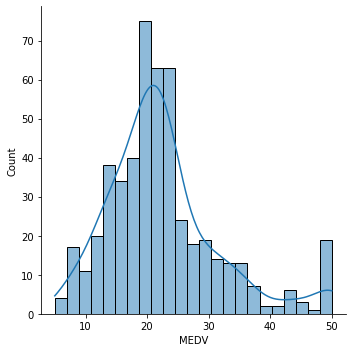

In [3]:
#Mirem de nou la distribució gràfica de MEDV:
sns.displot(data=HousingBoston, x="MEDV", kde=True)

In [4]:
#Com hem vist en l'exercici anterior la variable RAD es categorica i no està dumificada
#Per tant la dumifiquem abans de preprocessar les dades
HousingBoston_transf = pd.get_dummies(data = HousingBoston, columns= ['RAD'])
HousingBoston_transf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,MEDV,RAD_1,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296.0,15.3,...,24.0,1,0,0,0,0,0,0,0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242.0,17.8,...,21.6,0,1,0,0,0,0,0,0,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242.0,17.8,...,34.7,0,1,0,0,0,0,0,0,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222.0,18.7,...,33.4,0,0,1,0,0,0,0,0,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222.0,18.7,...,36.2,0,0,1,0,0,0,0,0,0


## 1.2 PreProcessat

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
#Preprocessem amb un Robust Scaler les dades que tenen outliers
columnsRobust = ['CRIM','ZN','RM','DIS','PTRATIO','B','LSTAT']
scaler = preprocessing.RobustScaler().fit(HousingBoston_transf[columnsRobust])
HousingBoston_transf[columnsRobust] = scaler.transform(HousingBoston_transf[columnsRobust])
HousingBoston_transf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,MEDV,RAD_1,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,-0.069593,1.44,2.31,0,0.538,0.496612,65.2,0.285777,296.0,-1.339286,...,24.0,1,0,0,0,0,0,0,0,0
1,-0.063755,0.00,7.07,0,0.469,0.287940,78.9,0.569789,242.0,-0.446429,...,21.6,0,1,0,0,0,0,0,0,0
2,-0.063760,0.00,7.07,0,0.469,1.323171,61.1,0.569789,242.0,-0.446429,...,34.7,0,1,0,0,0,0,0,0,0
3,-0.062347,0.00,2.18,0,0.458,1.069783,45.8,0.924391,222.0,-0.125000,...,33.4,0,0,1,0,0,0,0,0,0
4,-0.052144,0.00,2.18,0,0.458,1.271680,54.2,0.924391,222.0,-0.125000,...,36.2,0,0,1,0,0,0,0,0,0


In [6]:
from sklearn.preprocessing import MinMaxScaler
#Preprocessem amb un MinMaxScaler les dades que NO tenen outliers
columnsminmax = ['INDUS', 'NOX', 'TAX', 'AGE']
trans = MinMaxScaler()
HousingBoston_transf[columnsminmax] = trans.fit_transform(HousingBoston_transf[columnsminmax])
HousingBoston_transf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,MEDV,RAD_1,RAD_2,RAD_3,RAD_4,RAD_5,RAD_6,RAD_7,RAD_8,RAD_24
0,-0.069593,1.44,0.067815,0,0.314815,0.496612,0.641607,0.285777,0.208015,-1.339286,...,24.0,1,0,0,0,0,0,0,0,0
1,-0.063755,0.00,0.242302,0,0.172840,0.287940,0.782698,0.569789,0.104962,-0.446429,...,21.6,0,1,0,0,0,0,0,0,0
2,-0.063760,0.00,0.242302,0,0.172840,1.323171,0.599382,0.569789,0.104962,-0.446429,...,34.7,0,1,0,0,0,0,0,0,0
3,-0.062347,0.00,0.063050,0,0.150206,1.069783,0.441813,0.924391,0.066794,-0.125000,...,33.4,0,0,1,0,0,0,0,0,0
4,-0.052144,0.00,0.063050,0,0.150206,1.271680,0.528321,0.924391,0.066794,-0.125000,...,36.2,0,0,1,0,0,0,0,0,0


**REGRESSIO LINEAL**

Abans de definir el target miro la correlació de MEDV (Median value of owner-occupied homes in 1000 USD) amb la resta de variables.

Mirem la correlació i la regressió de la variable MEDV respecte les altres amb np.polyfit() aquesta funció serveix per fer una linea de regressió lineal al scatterplot de la variable x que en aquest representa cada columna respecte MEDV que serà la variable que es la linea en color en color verd. np.poly1d() crea una funció polinomica a  (una linea en aquest cas ) amb els coeficients generats per np.polyfit().
Agafo nomes les 13 primeres columnes per no agafar RAD que es un index categòric.

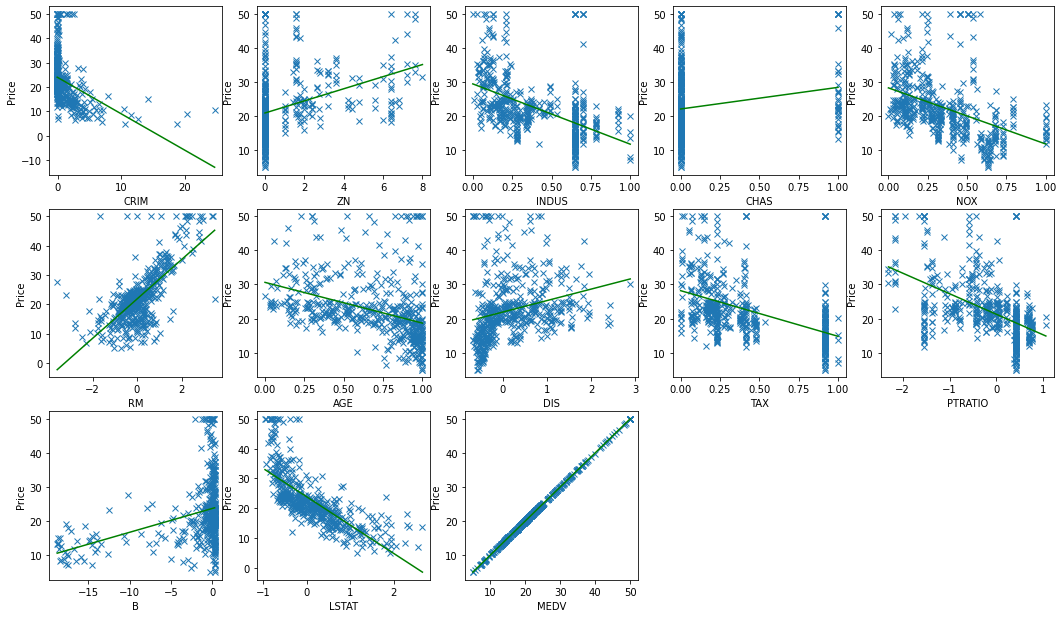

In [7]:
plt.figure(figsize=(18, 18))

for i, idx in enumerate(HousingBoston_transf.columns[0:13]):
    plt.subplot(5, 5, i+1)
    x = HousingBoston_transf[idx]
    y = HousingBoston_transf['MEDV']
    plt.plot(x, y, 'x')
    
# Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1)) (np.unique(x)), color='green')
    plt.xlabel(idx)
    plt.ylabel('Price')

En funció d'aixó veiem que RM AGE TAX i LSTAT son els que tenen més correlació linear amb la variable objectiu MEDV.


In [8]:
from sklearn.model_selection import train_test_split
# Separo la bdd entre features i target posant al eix Y el target, no considero les variables categòriques RAD i CHAS
features = ['CRIM', 'ZN', 'RM', 'DIS','PTRATIO','B', 'LSTAT','INDUS', 'NOX','AGE', 'TAX']
target= ['MEDV']
X = HousingBoston_transf[features]
y = HousingBoston_transf[target]

Podem mirar si existeix multicolonialitat, es tracta d'un fenomen en què hi ha una correlació alta entre les variables d'un conjunt de dades, el que pot afectar negativament els resultats de les anàlisis estadístiques. Quan això passa, les variables afectades poden ser redundants, cosa que implica pèrdua de informació i modelatge més complex.

In [9]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ajustem un model lineal als nostres dades
model = sm.OLS(X, y)

# calculem el factor d'inflació de la variança per a cada variable
vif_array = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif_array)

[1.9164262719641896, 2.7670192092757926, 1.8997888921308737, 2.641357961852795, 1.8274382782068814, 1.5333474262108102, 2.6824901821260494, 11.359766870856298, 13.346194165392863, 9.721542977688593, 9.23821061220378]


En general, un valor de multicolonialitat superior a 5 o 10 indica una alta multicolinealidad. Veiem que la variable INDUS, NOX, AGE i TAX tenen unes multicolonialitats molt elevada, està altament correlacionada amb altres variables del conjunt de dades, el que pot afectar negativament les anàlisis estadístiques... I ho tindrem en compte per els resultats dels models predictius mes endavant.
Hem de tenir en compte:
*-"Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics. If your primary goal is to make predictions, and you don’t need to understand the role of each independent variable, you don’t need to reduce severe multicollinearity."-*
https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

La variable "TAX" podria tenir una relació no-lineal amb la variable objectiu "MEDV". 
Per exemple, podria ser que el creixement dels valor mig de vivenda ocupada no fos relacionat amb el que es paga de Impost per vivenda, per exemple pot ser que estigui relacionada amb el barri.

## 1.3 Separem amb Train i Test 

Es recomanable aplicar train i test abans d'aplicar la regressió lineal o qualsevol altre algorisme de machine learning.

Aquesta separació serveix per evitar l'overfitting (sobreajustament) del model, ja que si utilitzem totes les dades per entrenar el model, aquest es pot ajustar excessivament a les dades d'entrenament i 
no permetrà prediccions acurades sobre les dades de prova.

Per tant, dividim les dades en dos conjunts: entrenament i prova. La idea és utilitzar el conjunt d'entrenament per ajustar el model i el conjunt de prova per avaluar la seva precisió.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train.describe()


,CRIM,ZN,RM,DIS,PTRATIO,B,LSTAT,INDUS,NOX,AGE,TAX
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,0.961816,0.879703,0.086268,0.187904,-0.205888,-1.611188,0.142750,0.389492,0.354086,0.679653,0.431472
std,2.363608,1.835343,0.965179,0.691345,0.775367,4.291947,0.722140,0.251833,0.242091,0.289352,0.324530
min,-0.069593,0.000000,-3.587398,-0.672824,-2.303571,-18.761003,-0.962519,0.010264,0.000000,0.000000,0.000000
25%,-0.049104,0.000000,-0.436314,-0.362527,-0.598214,-0.784507,-0.418791,0.171188,0.131687,0.440525,0.179389
50%,0.001711,0.000000,0.000000,-0.021096,0.017857,-0.008634,0.003498,0.338343,0.314815,0.768280,0.281489
75%,1.012609,1.000000,0.539973,0.626253,0.410714,0.226286,0.574213,0.646628,0.539095,0.937436,0.914122
max,24.678377,8.000000,3.484417,2.888060,1.053571,0.261902,2.659670,1.000000,1.000000,1.000000,1.000000


Veiem que agafa el 80% de les dades per el train i el 20% per el test amb 404 i 102 registres:

In [11]:

y_test.describe()


,MEDV
count,102.000000
mean,23.461765
std,9.685500
min,6.300000
25%,17.575000
50%,20.500000
75%,27.875000
max,50.000000


## 1.4 Apliquem 3 Models: Linear Regression, Support Vector Machines i Random Forest Regression

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Apliquem el model de regressió lineal
model = LinearRegression()
# Entrenem el model a les dades d'entrenament amb fit
model.fit(X_train, y_train)
y_pred_linreg= model.predict(X_test)

print('La precisió del Training: ',model.score(X_train, y_train)*100)
print("La precisió del testing és: ", model.score(X_test, y_test)*100)
print("La precisió del Model de regressió lineal és : ", r2_score(y, model.predict(X))*100)

La precisió del Training:  72.22348226651218
La precisió del testing és:  71.39352418089831
La precisió del Model de regressió lineal és :  72.11108109376411


Veiem que la precisió es menor en les dades de test que en el entrenament. 
Podem verificar si existeix algun overfitting aplicant una regularització

R-squared score: 0.7139352418089832
Mitja cuadratica score: 26.572333498455965


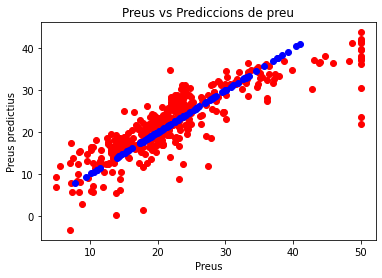

In [13]:

# Calculate the R-squared score

r2_linreg= r2_score(y_test, y_pred_linreg)
mse_linreg = mean_squared_error(y_test, y_pred_linreg)
print("R-squared score:", r2_linreg)
print("Mitja cuadratica score:", mse_linreg)

plt.scatter(y_train, model.predict(X_train), c='red', label='Actual', cmap='viridis')
plt.scatter(model.predict(X_test), y_pred_linreg, c='blue', label='Predicted', cmap='viridis')
#faig un scatter plot de les dades entrenades de preu en vermell i les prediccions de preu en blau
plt.xlabel("Preus")
plt.ylabel("Preus predictius")
plt.title("Preus vs Prediccions de preu")
plt.show()



-La MSE (mitja cuadràtica) indica com d'aprop està la regressió dels punts que veiem. Com mes petit és el MSE, millor serà el pronóstic.
-El R2 mesura la relació lineal entre X e Y, és la proporció de la variança en la variable dependent que es pot predir a partir de la variable independent.

In [14]:
from sklearn.svm import SVR
Model3 = SVR()
Model3.fit(X_train, y_train)
y_pred_svr = Model3.predict(X_test)
print('La precisió del training és: ', Model3.score(X_train, y_train)*100)
print("La precisió del testing és: ", Model3.score(X_test, y_test)*100)
print("La precisió del Model de Support Vector Machines és : ", r2_score(y, Model3.predict(X))*100)

La precisió del training és:  63.11931707338181
La precisió del testing és:  52.59119525425876
La precisió del Model de Support Vector Machines és :  60.8793085292345


R-squared score: 0.5259119525425876
Mitja cuadratica score: 44.037670995664


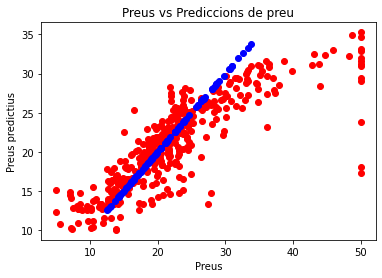

In [15]:
r2_SVR = r2_score(y_test, y_pred_svr)
mse_SVR = mean_squared_error(y_test, y_pred_svr)
print("R-squared score:", r2_SVR)
print("Mitja cuadratica score:", mse_SVR)

plt.scatter(y_train, Model3.predict(X_train), c='red', label='Actual', cmap='viridis')
plt.scatter(Model3.predict(X_test), y_pred_svr, c='blue', label='Predicted', cmap='viridis')
plt.xlabel("Preus")
plt.ylabel("Preus predictius")
plt.title("Preus vs Prediccions de preu")
plt.show()

In [16]:
model2 = RandomForestRegressor(random_state=45)
model2.fit(X_train, y_train)
y_pred_RFR = model2.predict(X_test)
print('La precisió del training és: ', model2.score(X_train, y_train)*100)
print("La precisió del testing és: ", model2.score(X_test, y_test)*100)
print("La precisió del Model de Random Forest és : ", r2_score(y, model2.predict(X))*100)


La precisió del training és:  97.81419840268822
La precisió del testing és:  82.39806993689666
La precisió del Model de Random Forest és :  94.40046064210202


R-squared score: 0.8239806993689666
Mitja cuadratica score: 16.350296303921574


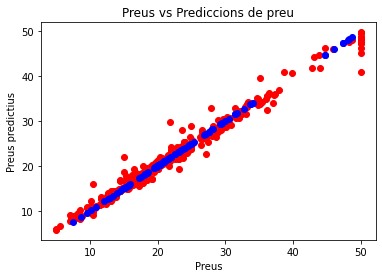

In [17]:
from sklearn.metrics import r2_score
r2_RFR = r2_score(y_test, y_pred_RFR)
mse_RFR = mean_squared_error(y_test, y_pred_RFR)
print("R-squared score:", r2_RFR)
print("Mitja cuadratica score:", mse_RFR)

plt.scatter(y_train, model2.predict(X_train), c='red', label='Actual', cmap='viridis')
plt.scatter(model2.predict(X_test), y_pred_RFR, c='blue', label='Predicted', cmap='viridis')
plt.xlabel("Preus")
plt.ylabel("Preus predictius")
plt.title("Preus vs Prediccions de preu")
plt.show()

Veiem que la precisió del training es molt alta i molt menor en les dades de test que en el entrenament. 
Aqui està clar que hi ha overfitting i haurem d'aplicar una regularització.

In [18]:
#comparo les prediccions 
y_pred_linreg = model.predict(X_test).ravel()
y_pred_svr = Model3.predict(X_test).ravel()
y_pred_RFR = model2.predict(X_test).ravel()

prediccion = pd.DataFrame({
    'PREDICCIÓ LIN REG': y_pred_linreg,
    'PREDICCIÓ RandomForest': y_pred_RFR,
    'PREDICCIÓ Support Vector Machine': y_pred_svr
})

prediccion.head(10)

,PREDICCIÓ LIN REG,PREDICCIÓ RandomForest,PREDICCIÓ Support Vector Machine
0,11.431908,18.080,17.054299
1,26.159208,24.483,25.947817
2,17.984879,19.670,18.892100
3,14.239719,18.446,15.701880
4,37.011154,48.140,31.934934
5,25.615975,24.065,23.868558
6,30.114797,34.099,26.746057
7,18.727771,18.180,18.185736
8,19.485864,15.255,14.241293
9,21.464063,15.938,20.403589


## - Exercici 2
- #### Compara’ls en base al MSE i al R2.

In [19]:
metrics = pd.DataFrame( data = [['Linear Regression', r2_linreg, mse_linreg],['Support Vector MACHINES', r2_SVR, mse_SVR],
                                  [' Random Forest Regressor', r2_RFR, mse_RFR]],
                                  columns = ['Model', 'R2', 'MSE'])
metrics.head()

,Model,R2,MSE
0,Linear Regression,0.713935,26.572333
1,Support Vector MACHINES,0.525912,44.037671
2,Random Forest Regressor,0.823981,16.350296


Com menor es el MSE, millor serà el pronòstic.
El R2 es una mida de la relació lineal entre X e Y, s'interpreta com la proporció de la variança en la variable depenent que es pot predir a partir de la variable independent.

-*Aqui veiem que el model Random Forest es molt millor que els altres models, ja que les mostres s'acosten molt mes a les prediccions.Tantmateix la MSE (mitja cuadràtica) es molt baixa e indica que està molt aprop de la regressió dels punts que veiem. 



És una bona pràctica utilitzar la validació creuada per comparar els resultats de R2 i MSE en diferents models de regressió, és un enfocament comú utilitzat en l'aprenentatge automàtic per avaluar el rendiment d'un model sobre dades no vistes.
 Després de cada iteració, puc calcular l'R2 i l'MSE del model al conjunt de proves i després fer una mitjana d'aquestes puntuacions en totes les k iteracions. Això ens donarà una estimació més precisa del rendiment del model amb dades noves i no vistes. Faig una mitja del R2 despres del **Cross Validation** :

In [20]:
from sklearn.model_selection import cross_val_score

cv_lr = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_RFR = cross_val_score(model2, X, y, cv=5, scoring='r2')
cv_SVR = cross_val_score(Model3, X, y, cv=5, scoring='r2')

cv_mean = [cv_lr.mean(),cv_RFR.mean(), cv_SVR.mean()]
metrics['R2 with CV'] = cv_mean
metrics.head()


,Model,R2,MSE,R2 with CV
0,Linear Regression,0.713935,26.572333,0.426400
1,Support Vector MACHINES,0.525912,44.037671,0.612125
2,Random Forest Regressor,0.823981,16.350296,0.243548


Overfitting happens when a model performs well on the training data but poorly on the testing or new data. 
To check for overfitting in your trained model, you can use the following approaches:

Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function.
A popular method is L1 or L2 regularization which adds a penalty term that is proportional to the magnitude
of the model weights. This technique forces the model to select only the most important features and reduces 
the magnitude of the weights, reducing the complexity of the model.

In [21]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge_reg = Ridge(alpha=0.8) # you can adjust the alpha parameter as needed
ridge_reg.fit(X_train, y_train)

ridge_train_pred = ridge_reg.predict(X_train)
ridge_test_pred = ridge_reg.predict(X_test)

train_rmse = mean_squared_error(y_train, ridge_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, ridge_test_pred, squared=False)

r2_Ridge= r2_score(y_test, ridge_test_pred )
mse_Ridge = mean_squared_error(y_test, ridge_test_pred)
print("R2 Ridge: ", r2_Ridge)
print("MSE: ", mse_Ridge)
print("Training RMSE: ", train_rmse)
print("Testing RMSE: ", test_rmse)

R2 Ridge:  0.7128441230422995
MSE:  26.673686674352528
Training RMSE:  4.7737442852096486
Testing RMSE:  5.16465745953713


En aquest cas veig que no millora els resultats.

## - Exercici 3
- #### Entrena’ls utilitzant els diferents paràmetres que admeten per intentar millorar-ne la predicció.

### Mirem els parametres de cada model:

### Definim parametres i modifiquem els possibles valors ###

GridSearchCV es una tecnica per trobar els valors dels hyperparametres optim de un set de parametres
en un grid. Es esencialment una tecnica de cross-validation . Has de posar el model i els parametres.
Despres de extreure els millors parametres, es fan les prediccions.

In [22]:
from sklearn.model_selection import GridSearchCV #Tècnica usada per ajustar hiperparàmetres dels models d'aprenentatge automàtic.

#### "Grid Search és adequat per a la definició dels hiperparàmetres dels models SVM i altres models de classificació, però no té sentit per a models de regressió lineal. Això és perquè la regressió lineal no té hiperparàmetres per ajustar. El model de regressió lineal ajusta els coeficients del model als valors de les variables d'entrada per tal de minimizar l'error quadràtic mitjà." 


Per tant nomes miraré en aquest cas si els parametres sugerits per GRIDSEARCH, coincideixen amb els parametres utilitzats per el nostre model de **LINEAR REGRESSION**

In [23]:
model.get_params() #LInear Regression parameters


{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [24]:
#definim parametres per LINEAR REGRESSION
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

In [25]:
grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(X, y)
print(grid.best_params_)

{'copy_X': True, 'fit_intercept': True, 'positive': False}


Com veiem coincideixen els mateixos valors que ja hem utilitzat amb el nostre model, per tant no te sentit intentar optimitzar-los.

Per tant, es millor definir i ajustar parametres per **RANDOM FOREST** ja que també és el que ens ha donat millors resultats:

In [26]:
model2.get_params() # parameters Support Vector Machines


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 45,
 'verbose': 0,
 'warm_start': False}

In [27]:
#definim parametres per RANDOM FOREST

param_gridRF = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_RF = GridSearchCV(model2, param_grid=param_gridRF, cv=5)
grid_RF.fit(X_train, y_train)
print(grid_RF.best_params_)

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [28]:

print(grid_RF.best_estimator_)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=150,
                      random_state=45)


Repetim el model indicant els parametres:

In [29]:
# Entrenem el model a les dades d'entrenament amb fit i els millors parametres
model2_bp = RandomForestRegressor(random_state=45,max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=50).fit(X_train,y_train)

y_pred_RFRbp = model2_bp.predict(X_test)
scoresRFRbp = cross_val_score(
            estimator=model2_bp, 
            X=X_train, 
            y=y_train, 
            cv=5,
)


print(scoresRFRbp) #miro la puntuació en 5 seccions diferents
print('La precisió del Training: ',model2_bp.score(X_train, y_train)*100)
print("La precisió del testing és: ", model2_bp.score(X_test, y_test)*100)
print("La precisió del Model Random Forest Regressor és : ", r2_score(y, model2_bp.predict(X))*100)


[0.85449517 0.86859241 0.91141923 0.87296128 0.77761683]
La precisió del Training:  97.49688885042765
La precisió del testing és:  85.4193417399876
La precisió del Model Random Forest Regressor és :  94.82448508039106


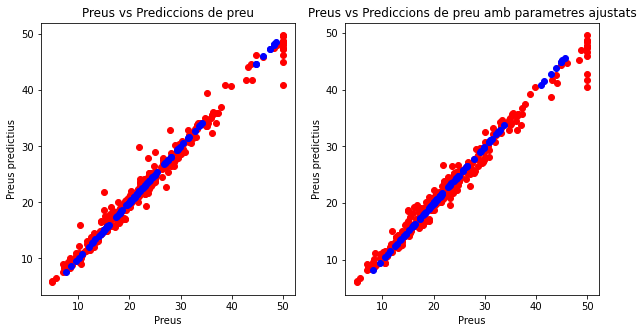

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Gràfic 1
ax1.scatter(y_train, model2.predict(X_train), c='red', label='Actual', cmap='viridis')
ax1.scatter(model2.predict(X_test), y_pred_RFR, c='blue', label='Predicted', cmap='viridis')
ax1.set_xlabel("Preus")
ax1.set_ylabel("Preus predictius")
ax1.set_title("Preus vs Prediccions de preu")

# Gràfic 2
ax2.scatter(y_train, model2_bp.predict(X_train), c='red', label='Actual', cmap='viridis')
ax2.scatter(model2_bp.predict(X_test), y_pred_RFRbp, c='blue', label='Predicted', cmap='viridis')
ax2.set_xlabel("Preus")
ax2.set_ylabel("Preus predictius")
ax2.set_title("Preus vs Prediccions de preu amb parametres ajustats")

plt.show()

Veiem que la precisió del testing i del model en si,  ha millorat pero encara demostra un overfitting important.

També mirem si ajustant parametres per **SUPPORT VECTOR MACHINES** milloren els resultats:

In [31]:
Model3.get_params() # parameters Support Vector Machines 

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [32]:
from sklearn.svm import SVC
param_gridSVM = {
    'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
    'C' : [1,5,10],
    'degree' : [3,8],
    'coef0' : [0.01,10,0.5],
    'gamma' : ('auto','scale')
}

In [ ]:

SVMsearch = RandomizedSearchCV(estimator=Model3,
                             param_distributions=param_gridSVM,cv=5,
                             n_iter=10,random_state=45,scoring='r2')
SVMsearch.fit(X, y)
print(SVMsearch.best_score_)
print(SVMsearch.best_params_)


In [ ]:
# Entrenem el model a les dades d'entrenament amb fit i els millors parametres
Model3_bp = SVR(kernel='rbf', gamma='auto',degree= 8,coef0= 0.5,C= 10).fit(X_train,y_train)

y_pred_SVRbp = Model3_bp.predict(X_test)
scoresSVRbp = cross_val_score(
            estimator=Model3_bp, 
            X=X_train, 
            y=y_train, 
            cv=5,
)

print(scoresSVRbp) #miro la puntuació en 5 seccions diferents
print('La precisió del Training: ',Model3_bp.score(X_train, y_train)*100)
print("La precisió del testing és: ", Model3_bp.score(X_test, y_test)*100)
print("La precisió del Model Support Vector Machines és : ", r2_score(y, Model3_bp.predict(X))*100)

Veiem també que amb SVM també millora molt la precisió i per tant les prediccions. Veiem-ho gràficament:
    

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Gràfic 1
ax1.scatter(y_train, Model3.predict(X_train), c='red', label='Actual', cmap='viridis')
ax1.scatter(Model3.predict(X_test), y_pred_svr, c='blue', label='Predicted', cmap='viridis')
ax1.set_xlabel("Preus")
ax1.set_ylabel("Preus predictius")
ax1.set_title("Preus vs Prediccions de preu")


# Gràfic 2
ax2.scatter(y_train, Model3_bp.predict(X_train), c='red', label='Actual', cmap='viridis')
ax2.scatter(Model3_bp.predict(X_test), y_pred_SVRbp, c='blue', label='Predicted', cmap='viridis')
ax2.set_xlabel("Preus")
ax2.set_ylabel("Preus predictius")
ax2.set_title("Preus vs Prediccions de preu amb parametres ajustats")

plt.show()

Veiem clarament com ara les prediccions s'acosten molt mes a la mostra.

## Exercici 4

- #### Compara el seu rendiment emprant l’aproximació train/test o emprant totes les dades (validació interna).

In [ ]:
# Rendiment Linear Regression
scoresLR = cross_val_score(
            estimator=model, 
            X=X_train, 
            y=y_train, 
            cv=5,
)
scoresLRxy = cross_val_score(
            estimator=model, 
            X=X, 
            y=y, 
            cv=5,
)
print(np.mean(scoresLR))#miro la mitja de la puntuació en 5 seccions diferents
print(np.mean(scoresLRxy))#miro la mitja de la puntuació en 5 seccions diferents de tota la bdd

In [ ]:
# Rendiment Random Forest Regression
scoresRFRbp = cross_val_score(
            estimator=model2_bp, 
            X=X_train, 
            y=y_train, 
            cv=5,
)
scoresRFRbpxy = cross_val_score(
            estimator=model2_bp, 
            X=X, 
            y=y, 
            cv=5,
)
print(np.mean(scoresRFRbp))#miro la mitja de la puntuació en 5 seccions diferents
print(np.mean(scoresRFRbpxy)) #miro la mitja de la puntuació en 5 seccions diferents de tota la bdd

In [ ]:
# Rendiment Support Vector Machines
scoresSVRbp = cross_val_score(
            estimator=Model3_bp, 
            X=X_train, 
            y=y_train, 
            cv=5,
)
scoresSVRbpxy = cross_val_score(
            estimator=Model3_bp, 
            X=X, 
            y=y, 
            cv=5,
)
print(np.mean(scoresSVRbp))
print(np.mean(scoresSVRbpxy))

En tots els casos el rendiment sempre es millor emprant el train test i Random Forest segueix donant la millor predicció.
També hem vist en el Exercici 2 comparant el R2 amb el Cross Validation per X e Y que donava millor rendiment amb les dades de train.

## Exercici 5

- #### No facis servir la variable del nombre d'habitacions (RM) a l’hora de fer prediccions.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Separo la bdd entre features i target posant al eix Y el target, no considero les variables categòriques RAD i CHAS
features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
target = ['MEDV']
A = HousingBoston_transf[features]
b = HousingBoston_transf[target]

In [ ]:
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=45)

Miro la diferencia en les prediccions sense aquesta variable en el model de Random Forest ja que és el que ha donat millors resultats:

In [ ]:
modelRF = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=1,min_samples_split=2, n_estimators=50 )


modelRF.fit(A_train, b_train)
y_pred_RF = modelRF.predict(A_test)
print('La precisió del training és: ', modelRF.score(A_train, b_train)*100)
print("La precisió del testing és: ", modelRF.score(A_test, b_test)*100)
print("La precisió del Model de Random Forest és : ", r2_score(b, modelRF.predict(A))*100)


In [ ]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

# Gràfic 1
ax1.scatter(y_train, model2.predict(X_train), c='red', label='Actual', cmap='viridis')
ax1.scatter(model2.predict(X_test), y_pred_RFR, c='blue', label='Predicted', cmap='viridis')
ax1.set_xlabel("Preus")
ax1.set_ylabel("Preus predictius")
ax1.set_title("Preus vs Prediccions de preu")

# Gràfic 2
ax2.scatter(y_train, model2_bp.predict(X_train), c='red', label='Actual', cmap='viridis')
ax2.scatter(model2_bp.predict(X_test), y_pred_RFRbp, c='blue', label='Predicted', cmap='viridis')
ax2.set_xlabel("Preus")
ax2.set_ylabel("Preus predictius")
ax2.set_title("Preus vs Prediccions de preu amb parametres ajustats")

# Gràfic 3
ax3.scatter(b_train, modelRF.predict(A_train), c='red', label='Actual', cmap='viridis')
ax3.scatter(modelRF.predict(A_test), y_pred_RF, c='blue', label='Predicted', cmap='viridis')
ax3.set_xlabel("Preus")
ax3.set_ylabel("Preus predictius")
ax3.set_title("Preus vs Prediccions de preu amb parametres ajustats i sense RM")
plt.show()


Podem veure que dona pitjors resultats alhora de fer prediccions ja que com hem vist en el exercici anterior,
la variable RM es una de les variables mes correlacionades amb el Target ja que el nombre d'habitacions es un indicador del preu de la casa.